In [1]:
"""
LSTM States Spatial Analysis (v2 - Streamlined with Signed Correlations)
=========================================================================
Analyze how LSTM hidden states (h_n) and cell states (c_n) internally represent
meteorological processes NOT included as model inputs.

Key Improvements over v1:
- Preserves correlation SIGN (positive vs negative groups)
- Analyzes BOTH h_n and c_n with comparison
- Streamlined flow: Per-gauge -> Cell assignment -> Cluster generalization
"""
from pathlib import Path
import sys

import cartopy.crs as ccrs
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append("../")

from src.plots.hex_maps import hexes_plots_n
from src.readers.geom_reader import load_geodata
from src.utils.logger import setup_logger

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
log = setup_logger("chapter_three_v2", log_file="../logs/chapter_three_v2.log")

# Output directories
table_dir = Path("../res/chapter_three/tables")
table_dir.mkdir(parents=True, exist_ok=True)
image_dir = Path("../res/chapter_three/images")
image_dir.mkdir(parents=True, exist_ok=True)

print("Imports complete. Output directories ready.")

Imports complete. Output directories ready.


In [3]:
# =============================================================================
# Load Data: LSTM states, gauge geometries, hybrid clusters
# =============================================================================
# Load gauge geometries
ws, gauges = load_geodata(folder_depth="../")
common_index = gauges.index.to_list()
basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")

# Load hybrid cluster assignments
gauge_mapping = pd.read_csv(
    "../res/chapter_one/gauge_hybrid_mapping.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
hybrid_clusters = gauge_mapping["hybrid_class"]

# Load LSTM states (both h_n and c_n)
states_path = Path("../data/optimization/lstm_states_per_gauge/all_gauges_states.npz")
print(f"Loading LSTM states from: {states_path}")
states = np.load(states_path)
print(f"Available keys: {list(states.keys())}")

# Extract h_n (hidden state) - last timestep
raw_h = states["h_n"]
h_states = raw_h[:, -1, :] if len(raw_h.shape) == 3 else raw_h
n_samples, hidden_size = h_states.shape

# Extract c_n (cell state) - last timestep
raw_c = states["c_n"]
c_states = raw_c[:, -1, :] if len(raw_c.shape) == 3 else raw_c

print(f"\nh_n shape: {h_states.shape}")
print(f"c_n shape: {c_states.shape}")
print(f"Gauges: {len(gauges)}, Hybrid clusters: {hybrid_clusters.nunique()}")

Loading LSTM states from: ../data/optimization/lstm_states_per_gauge/all_gauges_states.npz
Available keys: ['h_n', 'c_n', 'gauge_ids', 'hidden_size', 'n_timesteps']

h_n shape: (996, 256)
c_n shape: (996, 256)
Gauges: 996, Hybrid clusters: 16


In [3]:
# =============================================================================
# Define meteorological parameters (NOT used as model inputs)
# =============================================================================
METEO_PARAMS = {
    "evaporation": {
        "path": Path("../data/meteo_grids_2024/gleam/E"),
        "column": "E",
        "description": "Испарение (GLEAM)",
    },
    "swe": {
        "path": Path(
            "../data/meteo_grids_2024/snow_and_subsurface/era5_land/snow_depth_water_equivalent"
        ),
        "column": "swe_e5l",
        "description": "Водный эквивалент снега (ERA5-Land)",
    },
    "snow_depth": {
        "path": Path("../data/meteo_grids_2024/snow_and_subsurface/era5_land/snow_depth"),
        "column": None,
        "description": "Глубина снега (ERA5-Land)",
    },
    "subsurface": {
        "path": Path(
            "../data/meteo_grids_2024/snow_and_subsurface/era5_land/sub_surface_runoff"
        ),
        "column": None,
        "description": "Подземный сток (ERA5-Land)",
    },
}

# Color scheme for signed process groups
PROCESS_COLORS = {
    "evaporation_pos": "#27ae60",  # Green
    "evaporation_neg": "#1e8449",  # Dark Green
    "swe_pos": "#3498db",  # Blue
    "swe_neg": "#1a5276",  # Dark Blue
    "snow_depth_pos": "#9b59b6",  # Purple
    "snow_depth_neg": "#6c3483",  # Dark Purple
    "subsurface_pos": "#e67e22",  # Orange
    "subsurface_neg": "#a04000",  # Dark Orange
    "inactive": "#bdc3c7",  # Gray
}

# Minimum correlation threshold
MIN_CORRELATION = 0.3

# Verify paths
for param, info in METEO_PARAMS.items():
    exists = info["path"].exists()
    n_files = len(list(info["path"].glob("*.csv"))) if exists else 0
    print(f"{param}: exists={exists}, files={n_files}")

evaporation: exists=True, files=2246
swe: exists=True, files=2241
snow_depth: exists=True, files=2241
subsurface: exists=True, files=2241


In [4]:
# =============================================================================
# Core correlation functions (preserving sign)
# =============================================================================
def compute_cell_correlations(
    cell_states: np.ndarray,  # Shape: (n_timesteps, hidden_size)
    meteo_array: np.ndarray,  # Shape: (n_timesteps,)
) -> np.ndarray:
    """
    Compute SIGNED Pearson correlation between each LSTM cell and meteo data.
    Returns array of shape (hidden_size,) with signed correlation coefficients.
    """
    min_len = min(len(cell_states), len(meteo_array))
    cell_states = cell_states[:min_len]
    meteo_array = meteo_array[:min_len]

    valid_mask = ~np.isnan(meteo_array)
    if valid_mask.sum() < 30:
        return np.full(cell_states.shape[1], np.nan)

    cell_states = cell_states[valid_mask]
    meteo_array = meteo_array[valid_mask]

    n_cells = cell_states.shape[1]
    correlations = np.zeros(n_cells)

    for i in range(n_cells):
        try:
            corr_matrix = np.corrcoef(cell_states[:, i], meteo_array)
            correlations[i] = corr_matrix[0, 1]  # SIGNED correlation
        except Exception:
            correlations[i] = np.nan

    return correlations


def load_meteo_data(gauge_id: str, param_name: str) -> np.ndarray:
    """Load meteorological data for a specific gauge."""
    info = METEO_PARAMS[param_name]
    file_path = info["path"] / f"{gauge_id}.csv"

    if not file_path.exists():
        return np.array([])

    try:
        df = pd.read_csv(file_path, index_col="date", parse_dates=["date"])
        col = info["column"] if info["column"] else df.columns[0]
        if col not in df.columns:
            col = df.columns[0]
        return df[col].values
    except Exception:
        return np.array([])


print("Correlation functions defined (sign-preserving).")

Correlation functions defined (sign-preserving).


In [5]:
# =============================================================================
# Compute per-gauge correlation matrices for h_n and c_n
# Result: SIGNED correlations (not absolute values)
# =============================================================================
def compute_all_correlations(cell_states_array, state_name="h_n"):
    """Compute correlation matrices for all meteo params given cell states."""
    correlation_matrices = {}

    for param_name in METEO_PARAMS.keys():
        print(f"\n{state_name} - Processing: {param_name}")

        corr_df = pd.DataFrame(
            index=common_index,
            columns=range(hidden_size),
            dtype=float,
        )

        success_count = 0
        for gauge_id in tqdm(common_index, desc=param_name):
            meteo_data = load_meteo_data(gauge_id, param_name)

            if len(meteo_data) == 0:
                continue

            correlations = compute_cell_correlations(cell_states_array, meteo_data)

            if not np.all(np.isnan(correlations)):
                corr_df.loc[gauge_id] = correlations
                success_count += 1

        correlation_matrices[param_name] = corr_df.dropna(how="all")
        print(
            f"  Valid gauges: {success_count}, Shape: {correlation_matrices[param_name].shape}"
        )

    return correlation_matrices


# Compute for h_n (hidden state)
print("=" * 70)
print("Computing SIGNED correlations for h_n (hidden state)")
print("=" * 70)
h_correlation_matrices = compute_all_correlations(h_states, "h_n")

# Compute for c_n (cell state)
print("\n" + "=" * 70)
print("Computing SIGNED correlations for c_n (cell state)")
print("=" * 70)
c_correlation_matrices = compute_all_correlations(c_states, "c_n")

print("\nCorrelation computation complete!")

Computing SIGNED correlations for h_n (hidden state)

h_n - Processing: evaporation


evaporation:   0%|          | 0/996 [00:00<?, ?it/s]

  Valid gauges: 996, Shape: (996, 256)

h_n - Processing: swe


swe:   0%|          | 0/996 [00:00<?, ?it/s]

  Valid gauges: 996, Shape: (996, 256)

h_n - Processing: snow_depth


snow_depth:   0%|          | 0/996 [00:00<?, ?it/s]

  Valid gauges: 996, Shape: (996, 256)

h_n - Processing: subsurface


subsurface:   0%|          | 0/996 [00:00<?, ?it/s]

  Valid gauges: 996, Shape: (996, 256)

Computing SIGNED correlations for c_n (cell state)

c_n - Processing: evaporation


evaporation:   0%|          | 0/996 [00:00<?, ?it/s]

  Valid gauges: 996, Shape: (996, 256)

c_n - Processing: swe


swe:   0%|          | 0/996 [00:00<?, ?it/s]

  Valid gauges: 996, Shape: (996, 256)

c_n - Processing: snow_depth


snow_depth:   0%|          | 0/996 [00:00<?, ?it/s]

  Valid gauges: 996, Shape: (996, 256)

c_n - Processing: subsurface


subsurface:   0%|          | 0/996 [00:00<?, ?it/s]

  Valid gauges: 996, Shape: (996, 256)

Correlation computation complete!


In [12]:
# =============================================================================
# Assign cells to SIGNED process groups using Z-SCORE ranking
# This ensures all processes get representation even if correlations differ
# =============================================================================
def assign_cells_to_signed_groups(correlation_matrices, state_name="h_n"):
    """
    Assign each cell to a signed process group using Z-score ranking.

    This method normalizes correlations within each process so that
    processes with inherently weaker correlations still get cells assigned.

    Returns:
        cell_assignment_df: DataFrame with cell assignments
        cell_groups: Dict mapping group names to cell IDs
    """
    all_params = list(METEO_PARAMS.keys())

    # Build matrix: cell_id x param -> mean SIGNED correlation
    cell_corr_matrix = pd.DataFrame(index=range(hidden_size))

    for param_name, corr_df in correlation_matrices.items():
        mean_corr = corr_df.mean()  # Preserves sign!
        cell_corr_matrix[param_name] = mean_corr.values

    # Compute Z-scores for each cell within each process
    # This normalizes so we compare "how good is this cell for this process"
    # rather than "which process has higher raw correlation"
    z_scores = pd.DataFrame(index=range(hidden_size))

    for param in all_params:
        col = cell_corr_matrix[param]
        # Z-score based on absolute correlation (preserving sign in assignment)
        z_scores[f"{param}_pos"] = (col.clip(lower=0) - col.clip(lower=0).mean()) / (
            col.clip(lower=0).std() + 1e-8
        )
        z_scores[f"{param}_neg"] = (
            col.clip(upper=0).abs() - col.clip(upper=0).abs().mean()
        ) / (col.clip(upper=0).abs().std() + 1e-8)

    # For each cell, find which signed group has highest Z-score
    cell_assignment = []

    for cell_id in range(hidden_size):
        cell_zscores = z_scores.loc[cell_id]
        cell_corrs = cell_corr_matrix.loc[cell_id]

        # Find best group by Z-score
        best_group = cell_zscores.idxmax()
        best_zscore = cell_zscores.max()

        # Get the actual correlation for this group
        base_process = best_group.rsplit("_", 1)[0]
        sign = best_group.rsplit("_", 1)[1]

        if sign == "pos":
            actual_r = cell_corrs[base_process] if cell_corrs[base_process] > 0 else 0
        else:
            actual_r = cell_corrs[base_process] if cell_corrs[base_process] < 0 else 0

        # Only assign if correlation meets minimum threshold
        if abs(actual_r) >= MIN_CORRELATION:
            primary = best_group
            primary_r = actual_r
        else:
            # Fall back to absolute best if Z-score winner doesn't meet threshold
            all_corrs = cell_corrs.abs()
            if all_corrs.max() >= MIN_CORRELATION:
                best_param = all_corrs.idxmax()
                if cell_corrs[best_param] >= 0:
                    primary = f"{best_param}_pos"
                    primary_r = cell_corrs[best_param]
                else:
                    primary = f"{best_param}_neg"
                    primary_r = cell_corrs[best_param]
            else:
                primary = "inactive"
                primary_r = 0

        cell_assignment.append(
            {
                "cell_id": cell_id,
                "primary_group": primary,
                "primary_r": primary_r,
                "evaporation_r": cell_corrs.get("evaporation", 0),
                "swe_r": cell_corrs.get("swe", 0),
                "snow_depth_r": cell_corrs.get("snow_depth", 0),
                "subsurface_r": cell_corrs.get("subsurface", 0),
            }
        )

    cell_assignment_df = pd.DataFrame(cell_assignment).set_index("cell_id")

    # Create groups dictionary
    cell_groups = {}
    for group in cell_assignment_df["primary_group"].unique():
        cell_groups[group] = cell_assignment_df[
            cell_assignment_df["primary_group"] == group
        ].index.tolist()

    return cell_assignment_df, cell_groups, cell_corr_matrix


# Apply to h_n
print("=" * 70)
print("Assigning h_n cells to SIGNED process groups (Z-score ranking)")
print("=" * 70)
h_cell_assignment, h_cell_groups, h_cell_corr_matrix = assign_cells_to_signed_groups(
    h_correlation_matrices, "h_n"
)

# Show mean correlation per process (diagnostic)
print("\nMean |r| per process across all cells:")
for param in METEO_PARAMS.keys():
    mean_r = h_cell_corr_matrix[param].abs().mean()
    print(f"  {param}: {mean_r:.4f}")

# Display summary
print("\nh_n Cell Group Distribution:")
print(h_cell_assignment["primary_group"].value_counts())

Assigning h_n cells to SIGNED process groups (Z-score ranking)

Mean |r| per process across all cells:
  evaporation: 0.4932
  swe: 0.3960
  snow_depth: 0.4308
  subsurface: 0.2157

h_n Cell Group Distribution:
primary_group
evaporation_pos    39
inactive           35
evaporation_neg    34
subsurface_neg     33
subsurface_pos     32
swe_neg            25
swe_pos            22
snow_depth_pos     18
snow_depth_neg     18
Name: count, dtype: int64


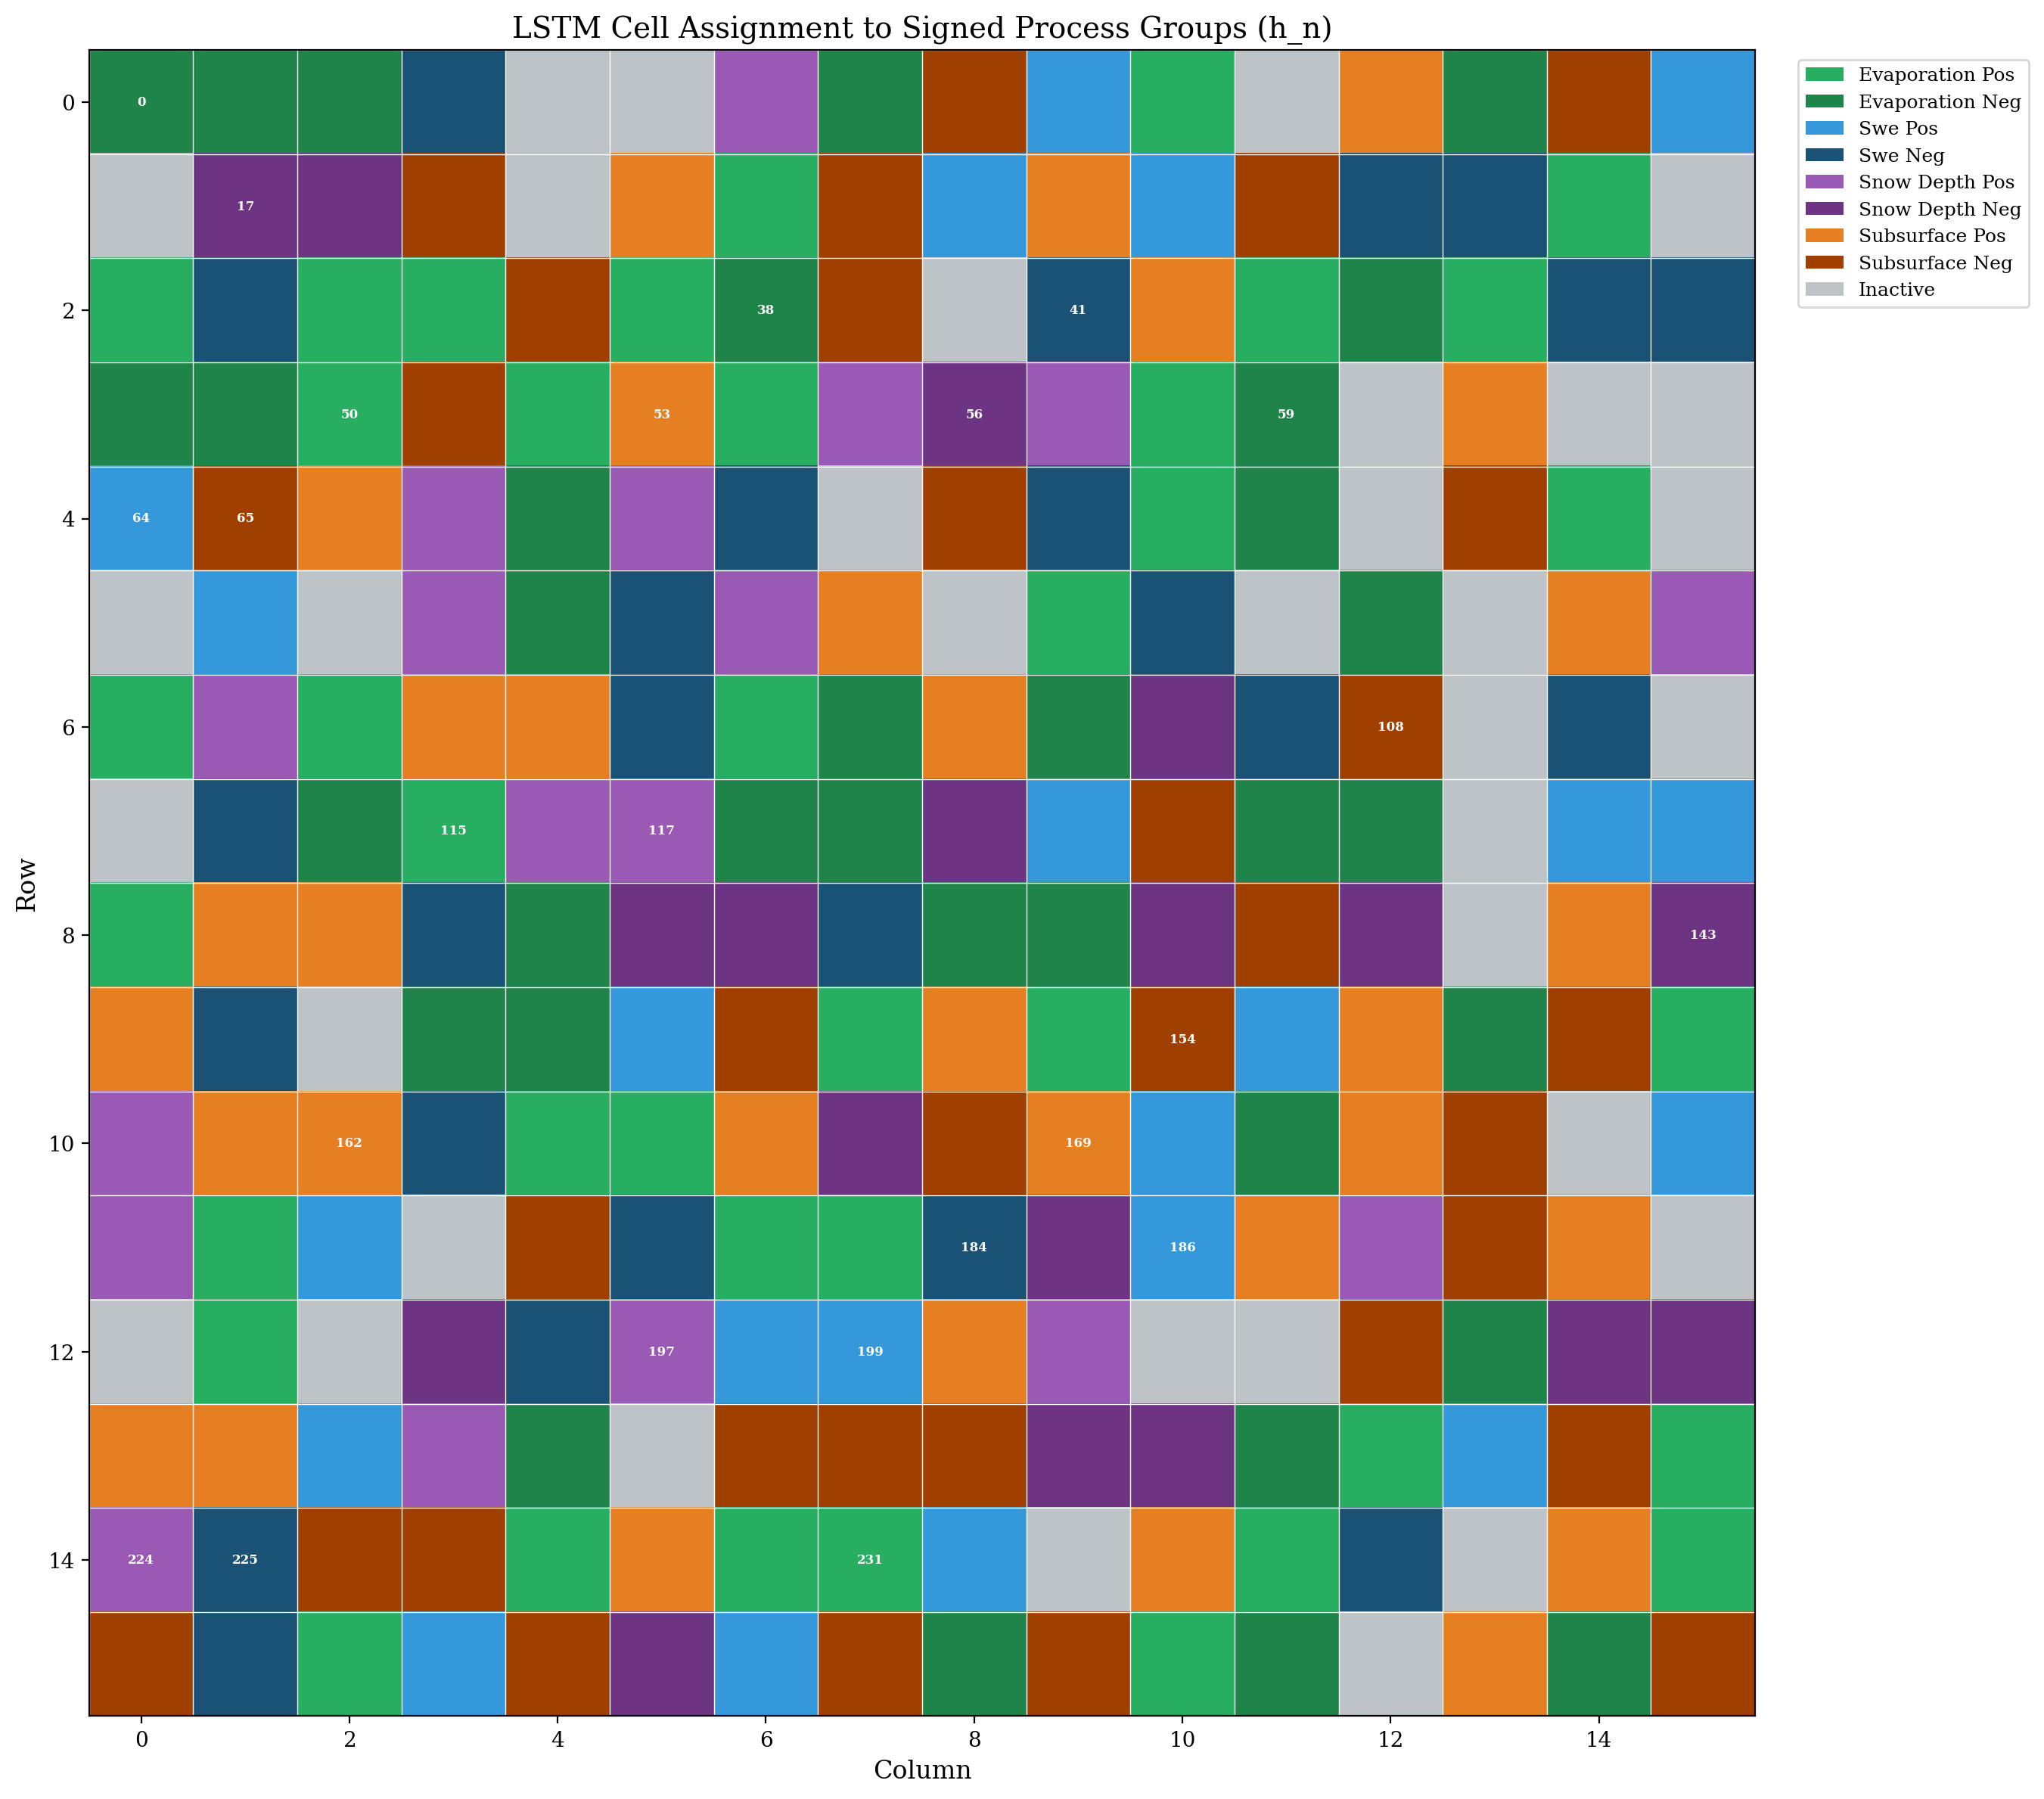

In [13]:
# =============================================================================
# Visualize Cell Grid (16x16) with Signed Groups
# =============================================================================
def plot_cell_grid(cell_assignment_df, title_suffix=""):
    """Plot 16x16 grid of LSTM cells colored by signed process group."""
    fig, ax = plt.subplots(figsize=(14, 12))

    grid_size = int(np.sqrt(hidden_size))
    cell_grid = np.zeros((grid_size, grid_size, 3))

    for cell_id in range(hidden_size):
        row = cell_id // grid_size
        col = cell_id % grid_size
        group = cell_assignment_df.loc[cell_id, "primary_group"]
        color_hex = PROCESS_COLORS.get(group, "#bdc3c7")
        rgb = tuple(int(color_hex.lstrip("#")[j : j + 2], 16) / 255 for j in (0, 2, 4))
        cell_grid[row, col] = rgb

    ax.imshow(cell_grid, aspect="equal")

    # Grid lines
    for i in range(grid_size + 1):
        ax.axhline(i - 0.5, color="white", linewidth=0.5)
        ax.axvline(i - 0.5, color="white", linewidth=0.5)

    # Label top 3 cells per group (by absolute correlation)
    for group, cells in h_cell_groups.items():
        if group == "inactive" or len(cells) == 0:
            continue
        subset = cell_assignment_df.loc[cells].copy()
        subset["abs_r"] = subset["primary_r"].abs()
        top_cells = subset.nlargest(3, "abs_r").index
        for cell_id in top_cells:
            row = cell_id // grid_size
            col = cell_id % grid_size
            ax.text(
                col,
                row,
                str(cell_id),
                ha="center",
                va="center",
                fontsize=6,
                color="white",
                fontweight="bold",
            )

    ax.set_xlabel("Column", fontsize=12)
    ax.set_ylabel("Row", fontsize=12)
    ax.set_title(
        f"LSTM Cell Assignment to Signed Process Groups{title_suffix}", fontsize=14
    )

    # Legend
    legend_elements = [
        Patch(facecolor=PROCESS_COLORS[g], label=g.replace("_", " ").title())
        for g in PROCESS_COLORS.keys()
        if g in h_cell_groups
    ]
    ax.legend(
        handles=legend_elements, loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=9
    )

    plt.tight_layout()
    return fig


fig = plot_cell_grid(h_cell_assignment, " (h_n)")
plt.savefig(image_dir / "lstm_v2_hn_signed_cell_grid.png", dpi=150, bbox_inches="tight")
plt.show()

In [14]:
# =============================================================================
# Summary Statistics Table for h_n Cell Groups
# =============================================================================
summary_data = []

for group, cells in h_cell_groups.items():
    if len(cells) == 0:
        continue

    subset = h_cell_assignment.loc[cells]
    avg_r = subset["primary_r"].mean()

    # Extract base process name
    if group == "inactive":
        process = "inactive"
        sign = "-"
    else:
        parts = group.rsplit("_", 1)
        process = parts[0]
        sign = "+" if parts[1] == "pos" else "-"

    summary_data.append(
        {
            "Group": group,
            "Process": process,
            "Sign": sign,
            "N Cells": len(cells),
            "Mean |r|": f"{abs(avg_r):.3f}",
            "Top 5 Cells": cells[:5],
        }
    )

summary_df = pd.DataFrame(summary_data)
print("=" * 70)
print("h_n CELL GROUP SUMMARY")
print("=" * 70)
print(summary_df[["Group", "N Cells", "Mean |r|"]].to_string(index=False))

# Verify no overlap
total = sum(len(cells) for cells in h_cell_groups.values())
print(f"\nTotal cells assigned: {total}/{hidden_size} (no overlap)")

h_n CELL GROUP SUMMARY
          Group  N Cells Mean |r|
evaporation_neg       34    0.601
        swe_neg       25    0.536
       inactive       35    0.000
 snow_depth_pos       18    0.671
 subsurface_neg       33    0.342
        swe_pos       22    0.566
evaporation_pos       39    0.574
 subsurface_pos       32    0.344
 snow_depth_neg       18    0.628

Total cells assigned: 256/256 (no overlap)


In [ ]:
# =============================================================================
# Gauge-level dominant process (with sign) - Z-score ranking
# =============================================================================
# For each gauge, find which signed process has highest Z-score
# This ensures all processes get representation (not just those with highest raw r)

common_gauges = set(common_index)
for param in h_correlation_matrices.values():
    common_gauges &= set(param.index)
common_gauges = list(common_gauges)

# Build gauge-level correlation matrix for Z-score normalization
# For each gauge, get the best cell correlation for each process
all_params = list(METEO_PARAMS.keys())
gauge_corr_matrix = pd.DataFrame(index=common_gauges)

for param_name, corr_df in h_correlation_matrices.items():
    # For each gauge, get best positive and best negative correlation
    gauge_corr_matrix[f"{param_name}_pos"] = (
        corr_df.loc[common_gauges].max(axis=1).clip(lower=0)
    )
    gauge_corr_matrix[f"{param_name}_neg"] = (
        corr_df.loc[common_gauges].min(axis=1).clip(upper=0).abs()
    )

# Compute Z-scores for each signed process group
gauge_zscores = pd.DataFrame(index=common_gauges)
for col in gauge_corr_matrix.columns:
    mean_val = gauge_corr_matrix[col].mean()
    std_val = gauge_corr_matrix[col].std() + 1e-8
    gauge_zscores[col] = (gauge_corr_matrix[col] - mean_val) / std_val

# For each gauge, assign to the group with highest Z-score
gauge_dominant = []

for gauge_id in common_gauges:
    z_vals = gauge_zscores.loc[gauge_id]
    best_group = z_vals.idxmax()

    # Get actual correlation value
    actual_r = gauge_corr_matrix.loc[gauge_id, best_group]
    if "_neg" in best_group:
        actual_r = -actual_r  # Restore negative sign

    gauge_dominant.append(
        {
            "gauge_id": gauge_id,
            "dominant_group": best_group,
            "max_r": actual_r,
            "z_score": z_vals.max(),
        }
    )

gauge_dominant_df = pd.DataFrame(gauge_dominant).set_index("gauge_id")
print("Gauge dominant process distribution (Z-score ranking):")
print(gauge_dominant_df["dominant_group"].value_counts())

Gauge dominant process distribution:
dominant_group
snow_depth_neg     348
snow_depth_pos     299
evaporation_neg    169
evaporation_pos     95
swe_neg             63
swe_pos             21
subsurface_neg       1
Name: count, dtype: int64


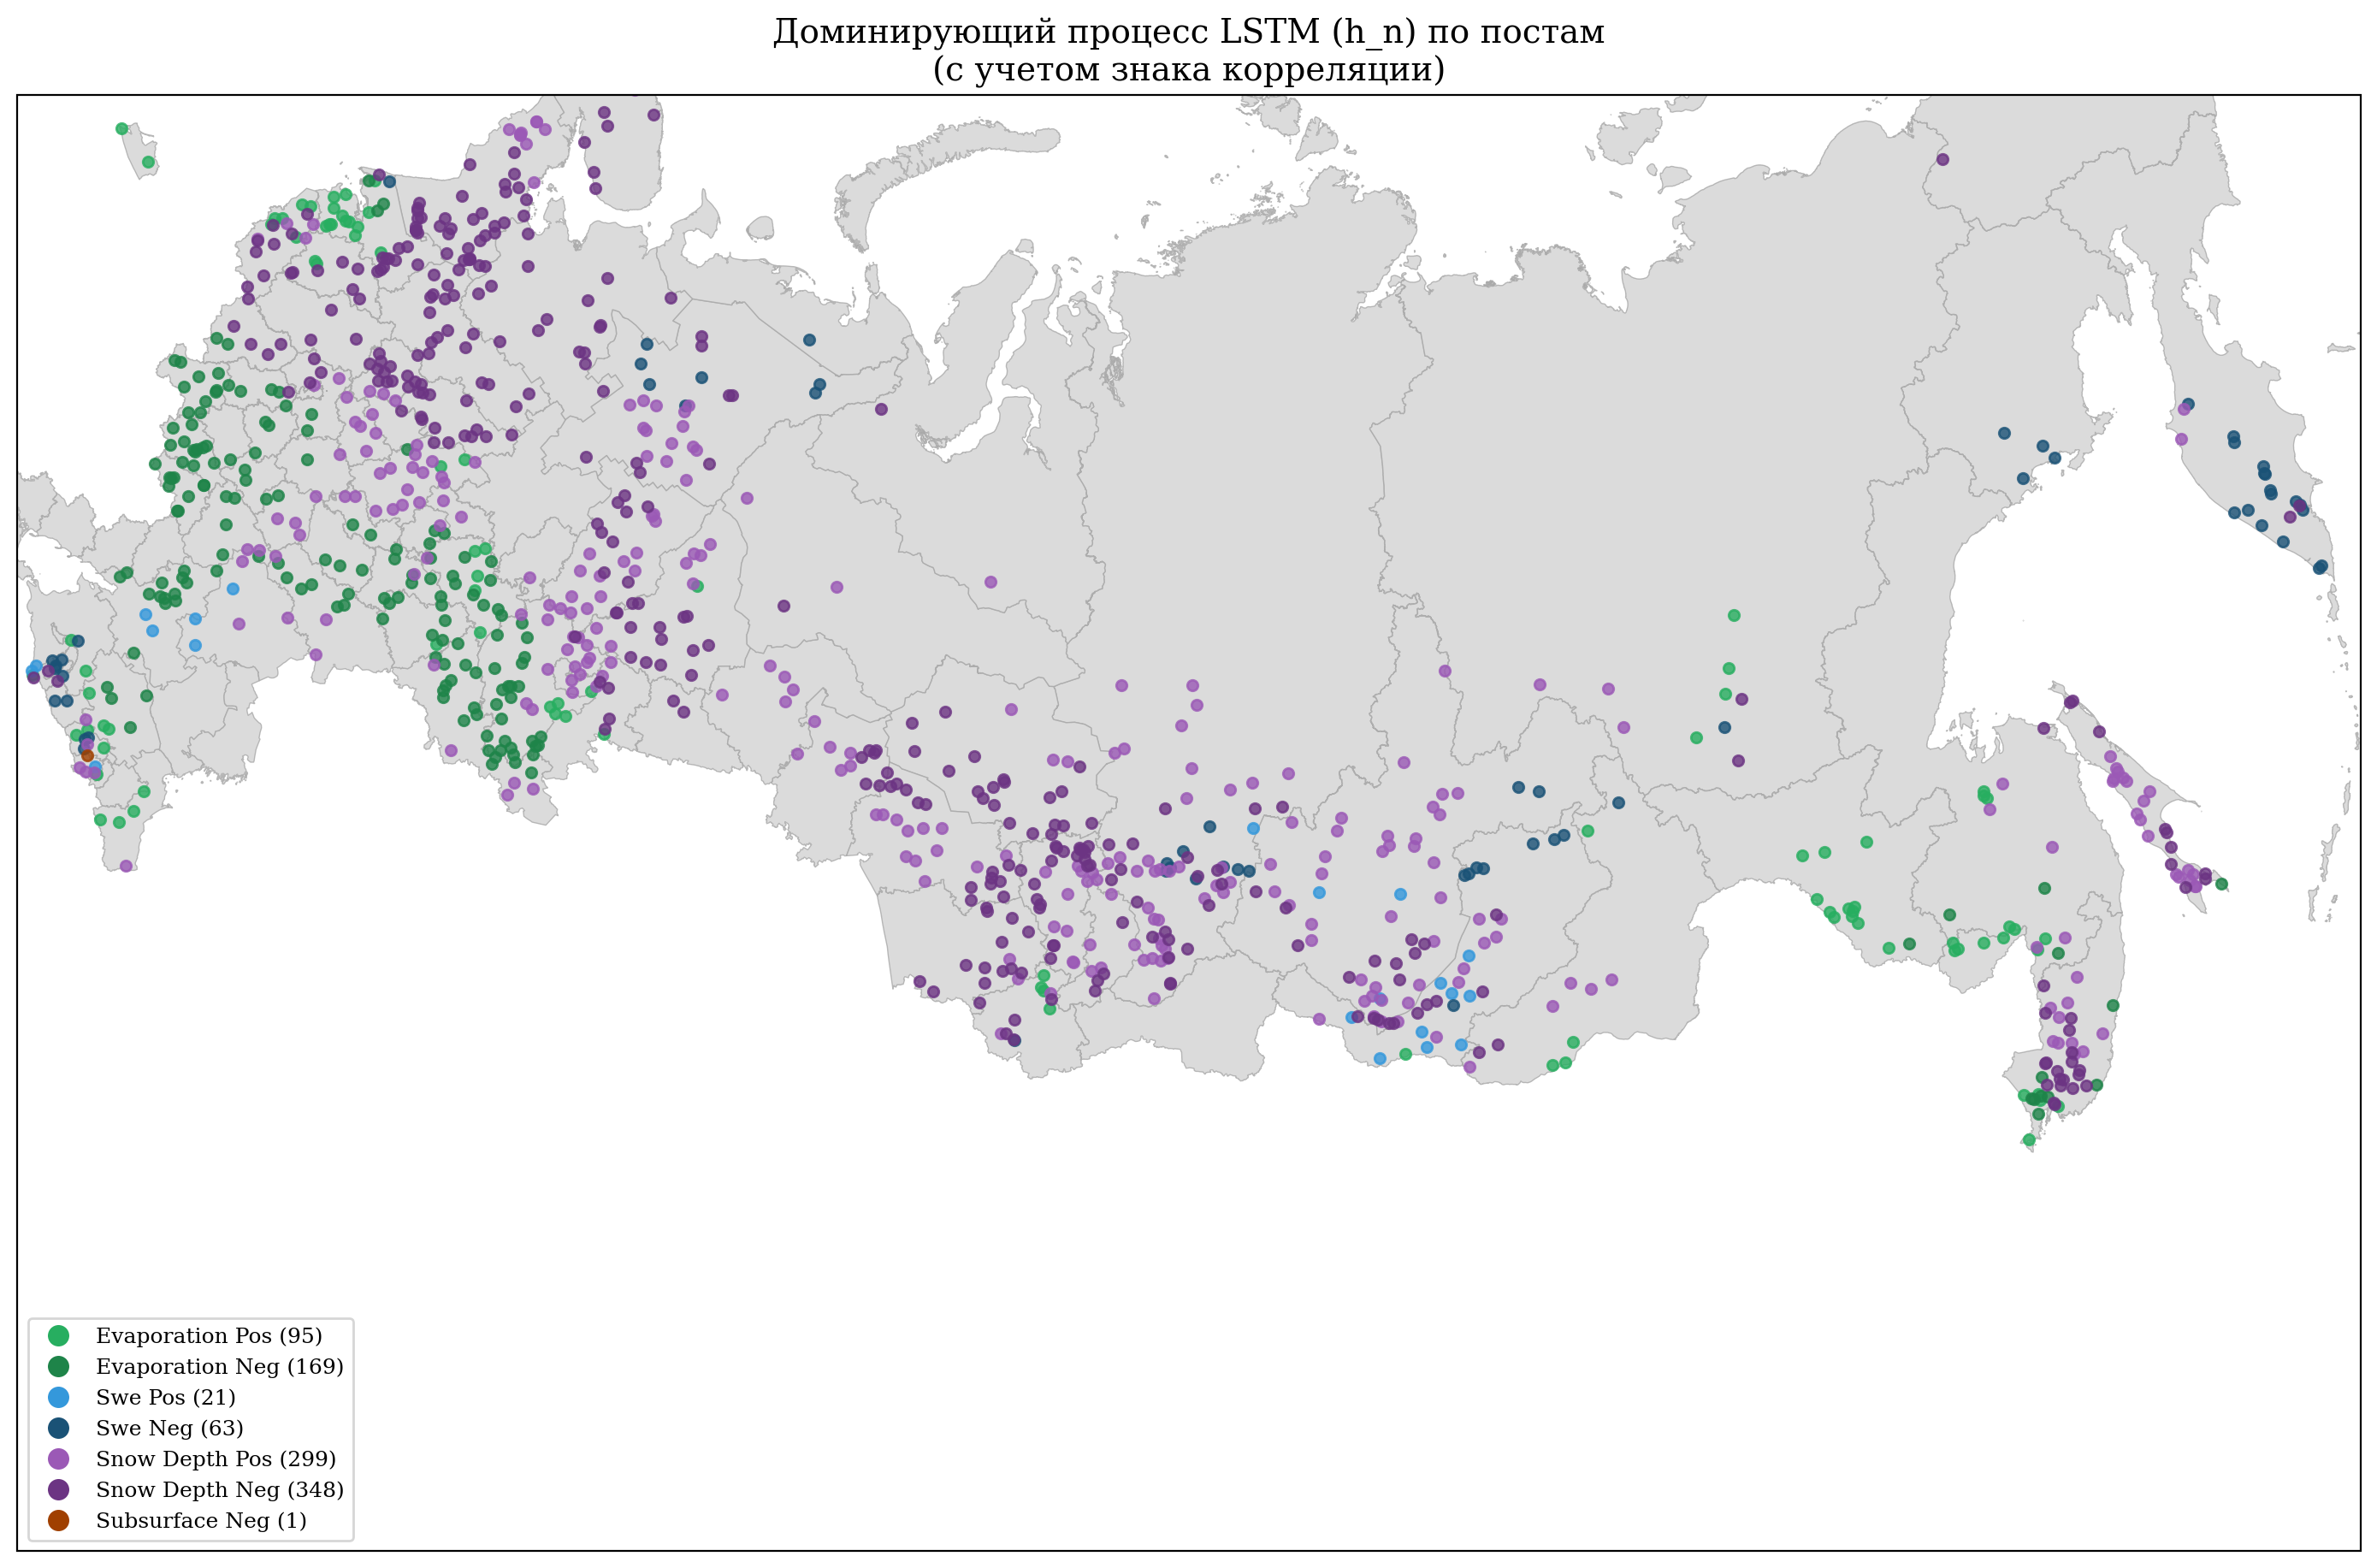

In [18]:
# =============================================================================
# Point Map: Gauge Dominant Process (with sign)
# =============================================================================
# Merge with gauge geometries
gauges_plot = gauges.copy()
gauges_plot = gauges_plot.join(gauge_dominant_df, how="inner")

fig, ax = plt.subplots(
    figsize=(14, 10),
    subplot_kw={
        "projection": ccrs.AlbersEqualArea(
            central_longitude=100,
            standard_parallels=(50, 70),
            central_latitude=56,
        )
    },
)

# Plot basemap
basemap_data.to_crs(ax.projection.proj4_init).plot(
    ax=ax, color="lightgray", edgecolor="darkgray", linewidth=0.5, alpha=0.8
)

# Plot gauges by dominant signed group
for group, color in PROCESS_COLORS.items():
    if group == "inactive":
        continue
    subset = gauges_plot[gauges_plot["dominant_group"] == group]
    if len(subset) > 0:
        subset.to_crs(ax.projection.proj4_init).plot(
            ax=ax, color=color, markersize=20, alpha=0.8
        )

# Legend
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color,
        markersize=10,
        label=f"{group.replace('_', ' ').title()} ({len(gauges_plot[gauges_plot['dominant_group'] == group])})",
    )
    for group, color in PROCESS_COLORS.items()
    if group in gauges_plot["dominant_group"].values
]
ax.legend(handles=legend_elements, loc="lower left", fontsize=9)

ax.set_title(
    "Доминирующий процесс LSTM (h_n) по постам\n(с учетом знака корреляции)", fontsize=14
)
ax.set_extent([50, 140, 35, 75], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.savefig(
    image_dir / "lstm_v2_hn_signed_dominant_process_map.png", dpi=150, bbox_inches="tight"
)
plt.show()

Watersheds with valid data: 996


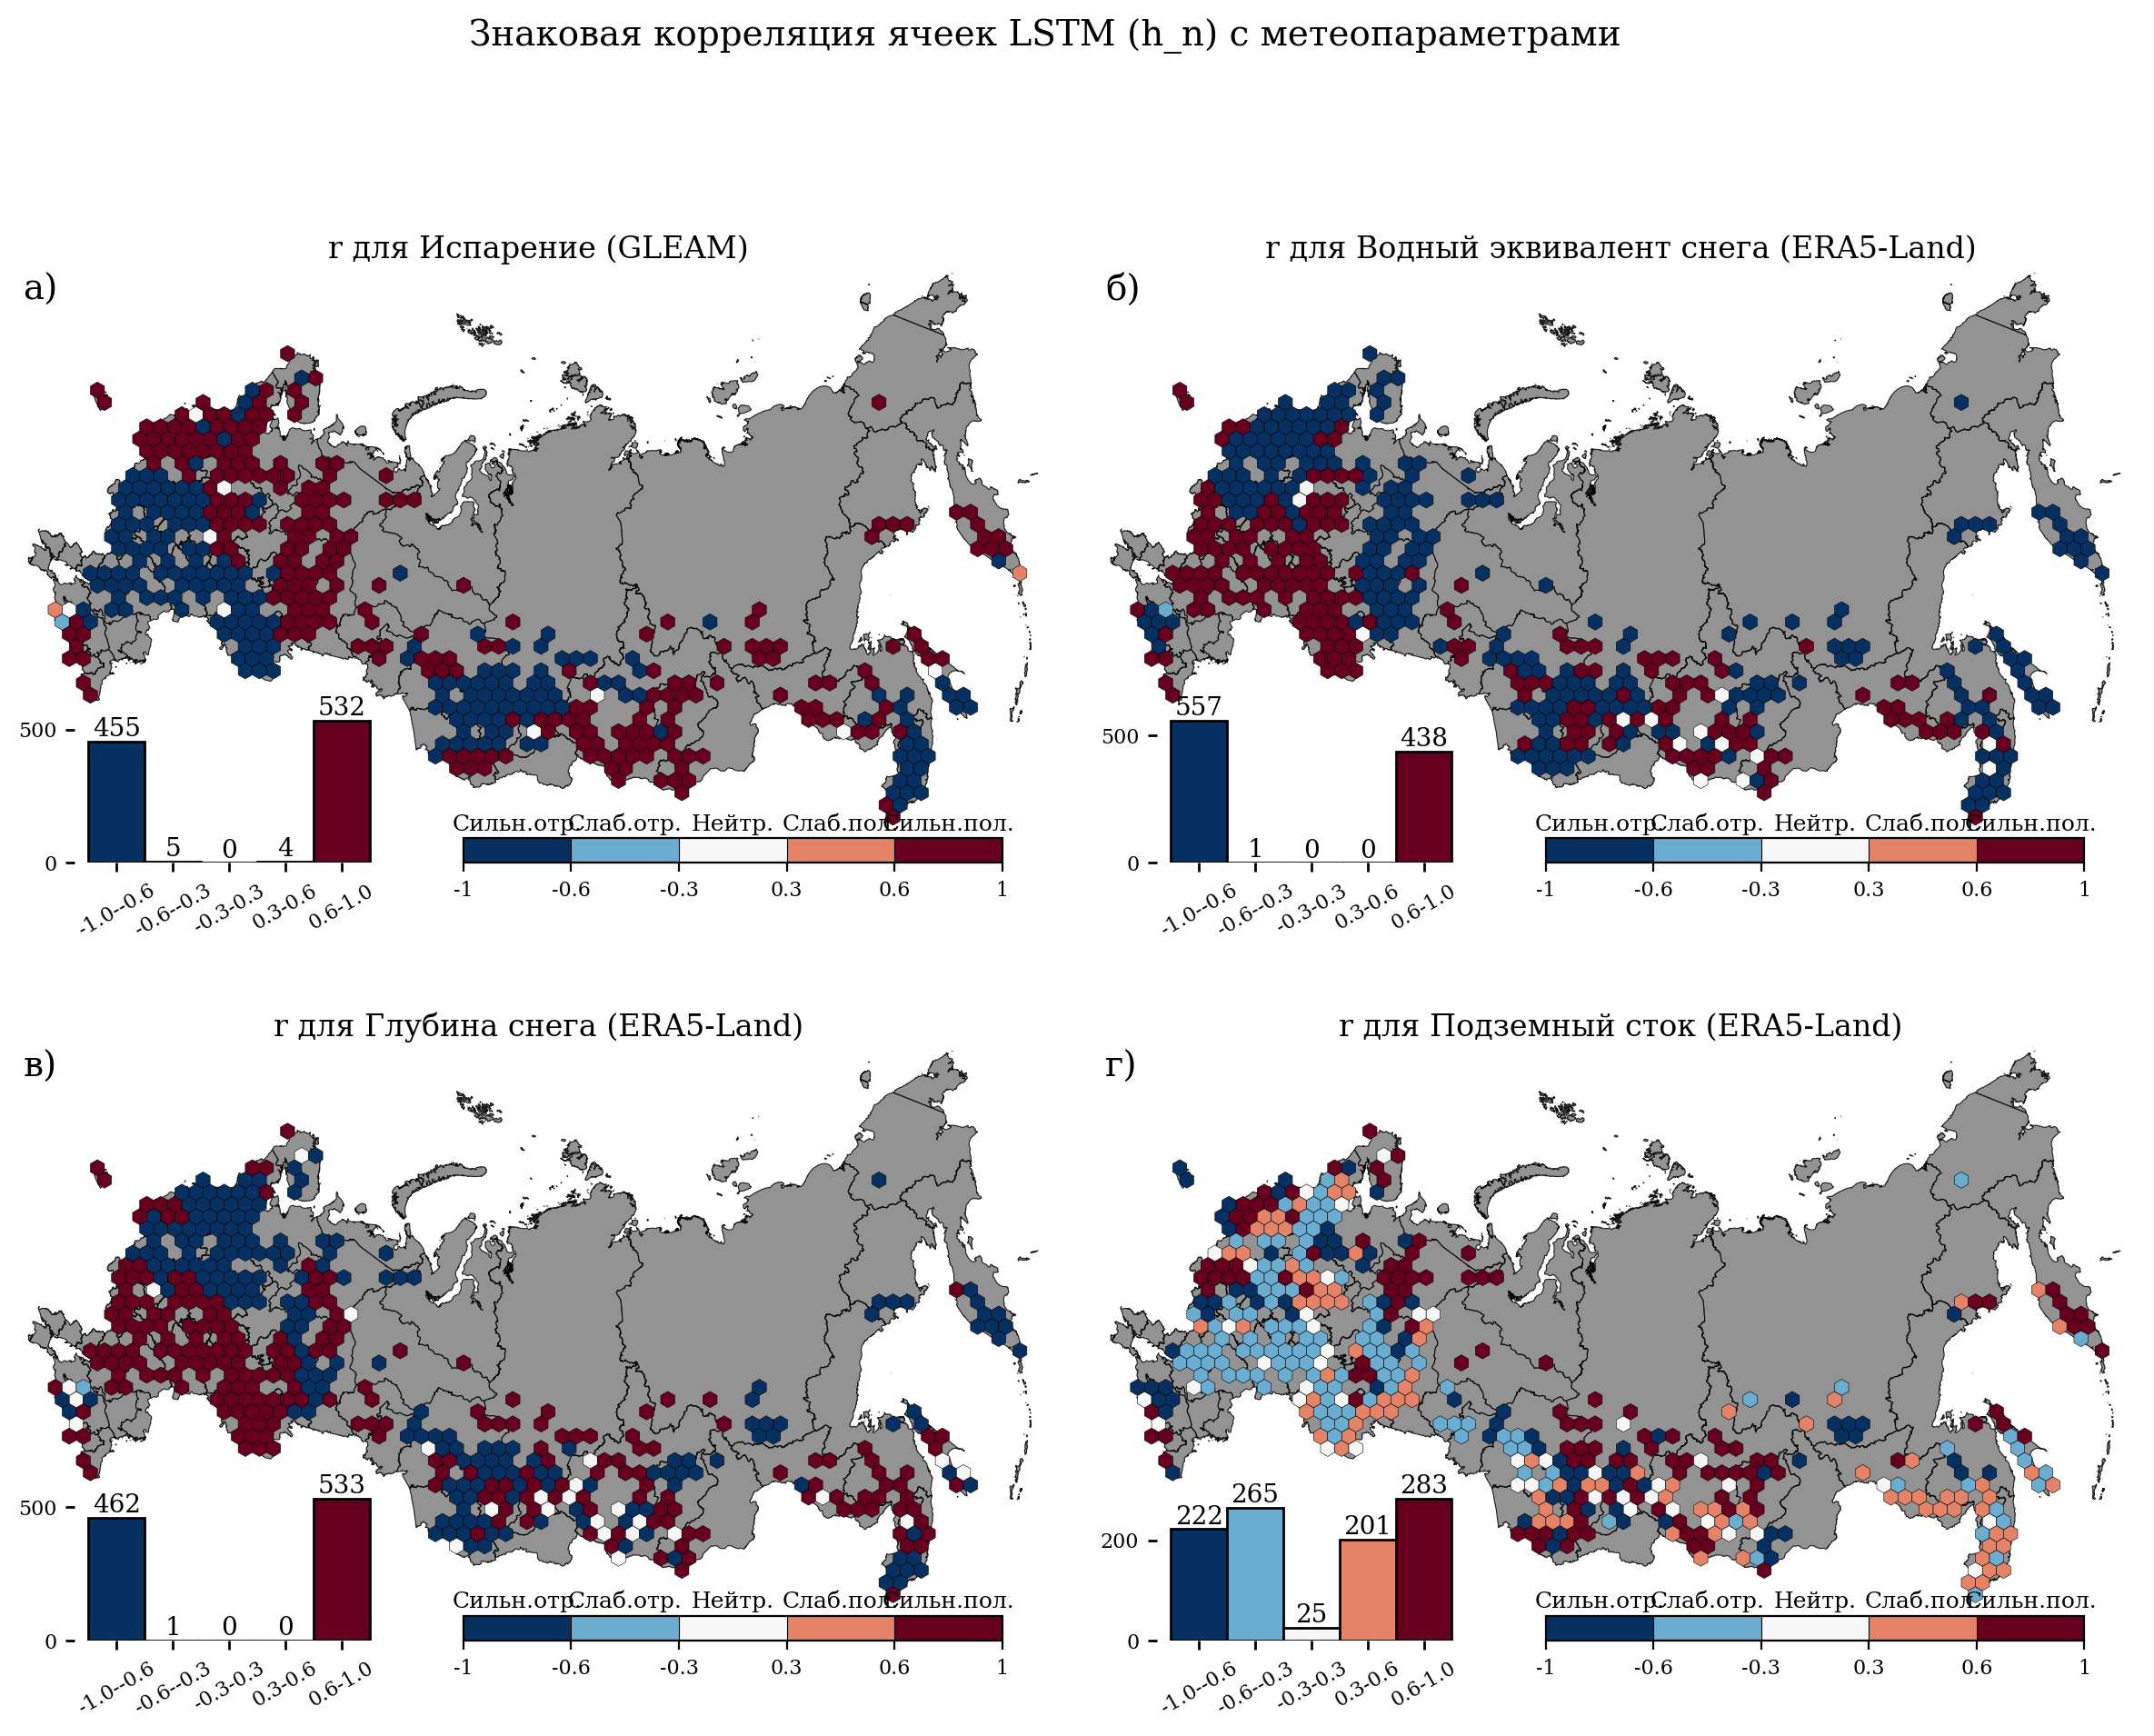

Hex radius: 66.0 km


In [19]:
# =============================================================================
# Hex Map: Signed correlation values (diverging colormap)
# =============================================================================
# Prepare data: for each gauge, get best signed correlation per process
ws_signed = ws.copy()

for param_name, corr_df in h_correlation_matrices.items():
    # Best positive correlation per gauge
    ws_signed[f"r_pos_{param_name}"] = corr_df.max(axis=1).reindex(ws_signed.index)
    # Best negative correlation per gauge
    ws_signed[f"r_neg_{param_name}"] = corr_df.min(axis=1).reindex(ws_signed.index)
    # Best overall (by magnitude) with sign preserved
    pos = corr_df.max(axis=1)
    neg = corr_df.min(axis=1)
    best = np.where(pos.abs() >= neg.abs().values, pos, neg)
    ws_signed[f"r_best_{param_name}"] = pd.Series(best, index=corr_df.index).reindex(
        ws_signed.index
    )

# Create hex maps with diverging colormap
metric_cols = [f"r_best_{p}" for p in METEO_PARAMS.keys()]
title_texts = [f"r для {METEO_PARAMS[p]['description']}" for p in METEO_PARAMS.keys()]

ws_valid = ws_signed.dropna(subset=metric_cols, how="all")
print(f"Watersheds with valid data: {len(ws_valid)}")

fig, hex_maps, radius_km, coverage_stats = hexes_plots_n(
    watersheds=ws_valid[["geometry"] + metric_cols],
    basemap_data=basemap_data,
    metric_cols=metric_cols,
    label_list=["а)", "б)", "в)", "г)"],
    nrows=2,
    ncols=2,
    target_ws_per_hex=6.0,
    area_weighted=False,
    min_overlap_share=0.15,
    quantile=0.5,
    list_of_limits=[-1.0, -0.6, -0.3, 0.3, 0.6, 1.0],
    cmap_name="RdBu_r",
    figsize=(15, 10),
    basemap_alpha=0.85,
    with_histogram=True,
    cb_label=["Сильн.отр.", "Слаб.отр.", "Нейтр.", "Слаб.пол.", "Сильн.пол."],
    title_text=title_texts,
)

plt.suptitle(
    "Знаковая корреляция ячеек LSTM (h_n) с метеопараметрами",
    fontsize=14,
    y=1.02,
)
plt.savefig(
    image_dir / "lstm_v2_hn_signed_correlation_hexmap.png", dpi=150, bbox_inches="tight"
)
plt.show()

print(f"Hex radius: {radius_km:.1f} km")

# Cluster Generalization Analysis

Aggregate per-gauge correlations by hybrid cluster to evaluate spatial consistency.

In [20]:
# =============================================================================
# Aggregate correlations by hybrid cluster
# =============================================================================
def aggregate_by_cluster(correlation_matrices):
    """Aggregate per-gauge correlations to cluster level using median."""
    cluster_correlations = {}

    for param_name, corr_df in correlation_matrices.items():
        cluster_corr = {}

        for cluster in sorted(hybrid_clusters.unique()):
            cluster_gauges = hybrid_clusters[hybrid_clusters == cluster].index
            cluster_gauges = cluster_gauges.intersection(corr_df.index)

            if len(cluster_gauges) >= 3:
                # Median SIGNED correlation for each cell
                cluster_corr[cluster] = corr_df.loc[cluster_gauges].median()

        cluster_correlations[param_name] = pd.DataFrame(cluster_corr).T

    return cluster_correlations


h_cluster_correlations = aggregate_by_cluster(h_correlation_matrices)

# Show sample
print("Cluster-aggregated correlations (h_n):")
for param, df in h_cluster_correlations.items():
    print(f"\n{param}: {df.shape}")
    # Top 3 cells by absolute correlation
    top_cells = df.abs().mean().nlargest(3).index.tolist()
    print(f"  Top cells: {top_cells}")

Cluster-aggregated correlations (h_n):

evaporation: (16, 256)
  Top cells: [231, 0, 59]

swe: (16, 256)
  Top cells: [41, 56, 143]

snow_depth: (16, 256)
  Top cells: [143, 197, 56]

subsurface: (16, 256)
  Top cells: [65, 39, 108]


In [21]:
# =============================================================================
# Cross-tabulation: cluster x dominant signed process
# =============================================================================
# Merge gauge dominant with cluster
gauge_cluster_df = gauge_dominant_df.copy()
gauge_cluster_df["cluster"] = hybrid_clusters.reindex(gauge_cluster_df.index)
gauge_cluster_df = gauge_cluster_df.dropna(subset=["cluster"])

# Cross-tabulation
crosstab = pd.crosstab(
    gauge_cluster_df["cluster"], gauge_cluster_df["dominant_group"], margins=True
)

print("=" * 70)
print("CLUSTER x DOMINANT SIGNED PROCESS")
print("=" * 70)
print(crosstab)

CLUSTER x DOMINANT SIGNED PROCESS
dominant_group  evaporation_neg  evaporation_pos  snow_depth_neg  \
cluster                                                            
Ф1-Г1                        28                1               0   
Ф1-Г3                        21                0               1   
Ф1-Г5                        57                4               7   
Ф10-Г1                        4                1              16   
Ф10-Г10                       0                0              21   
Ф10-Г3                       11               21              57   
Ф2-Mixed                     21               10               9   
Ф3-Г4                         0                9               3   
Ф4-Г8                         1               19              37   
Ф5-Г2                         2                1              41   
Ф6-Г10                        1                2              22   
Ф7-Г1                         7                1              33   
Ф7-Г2         

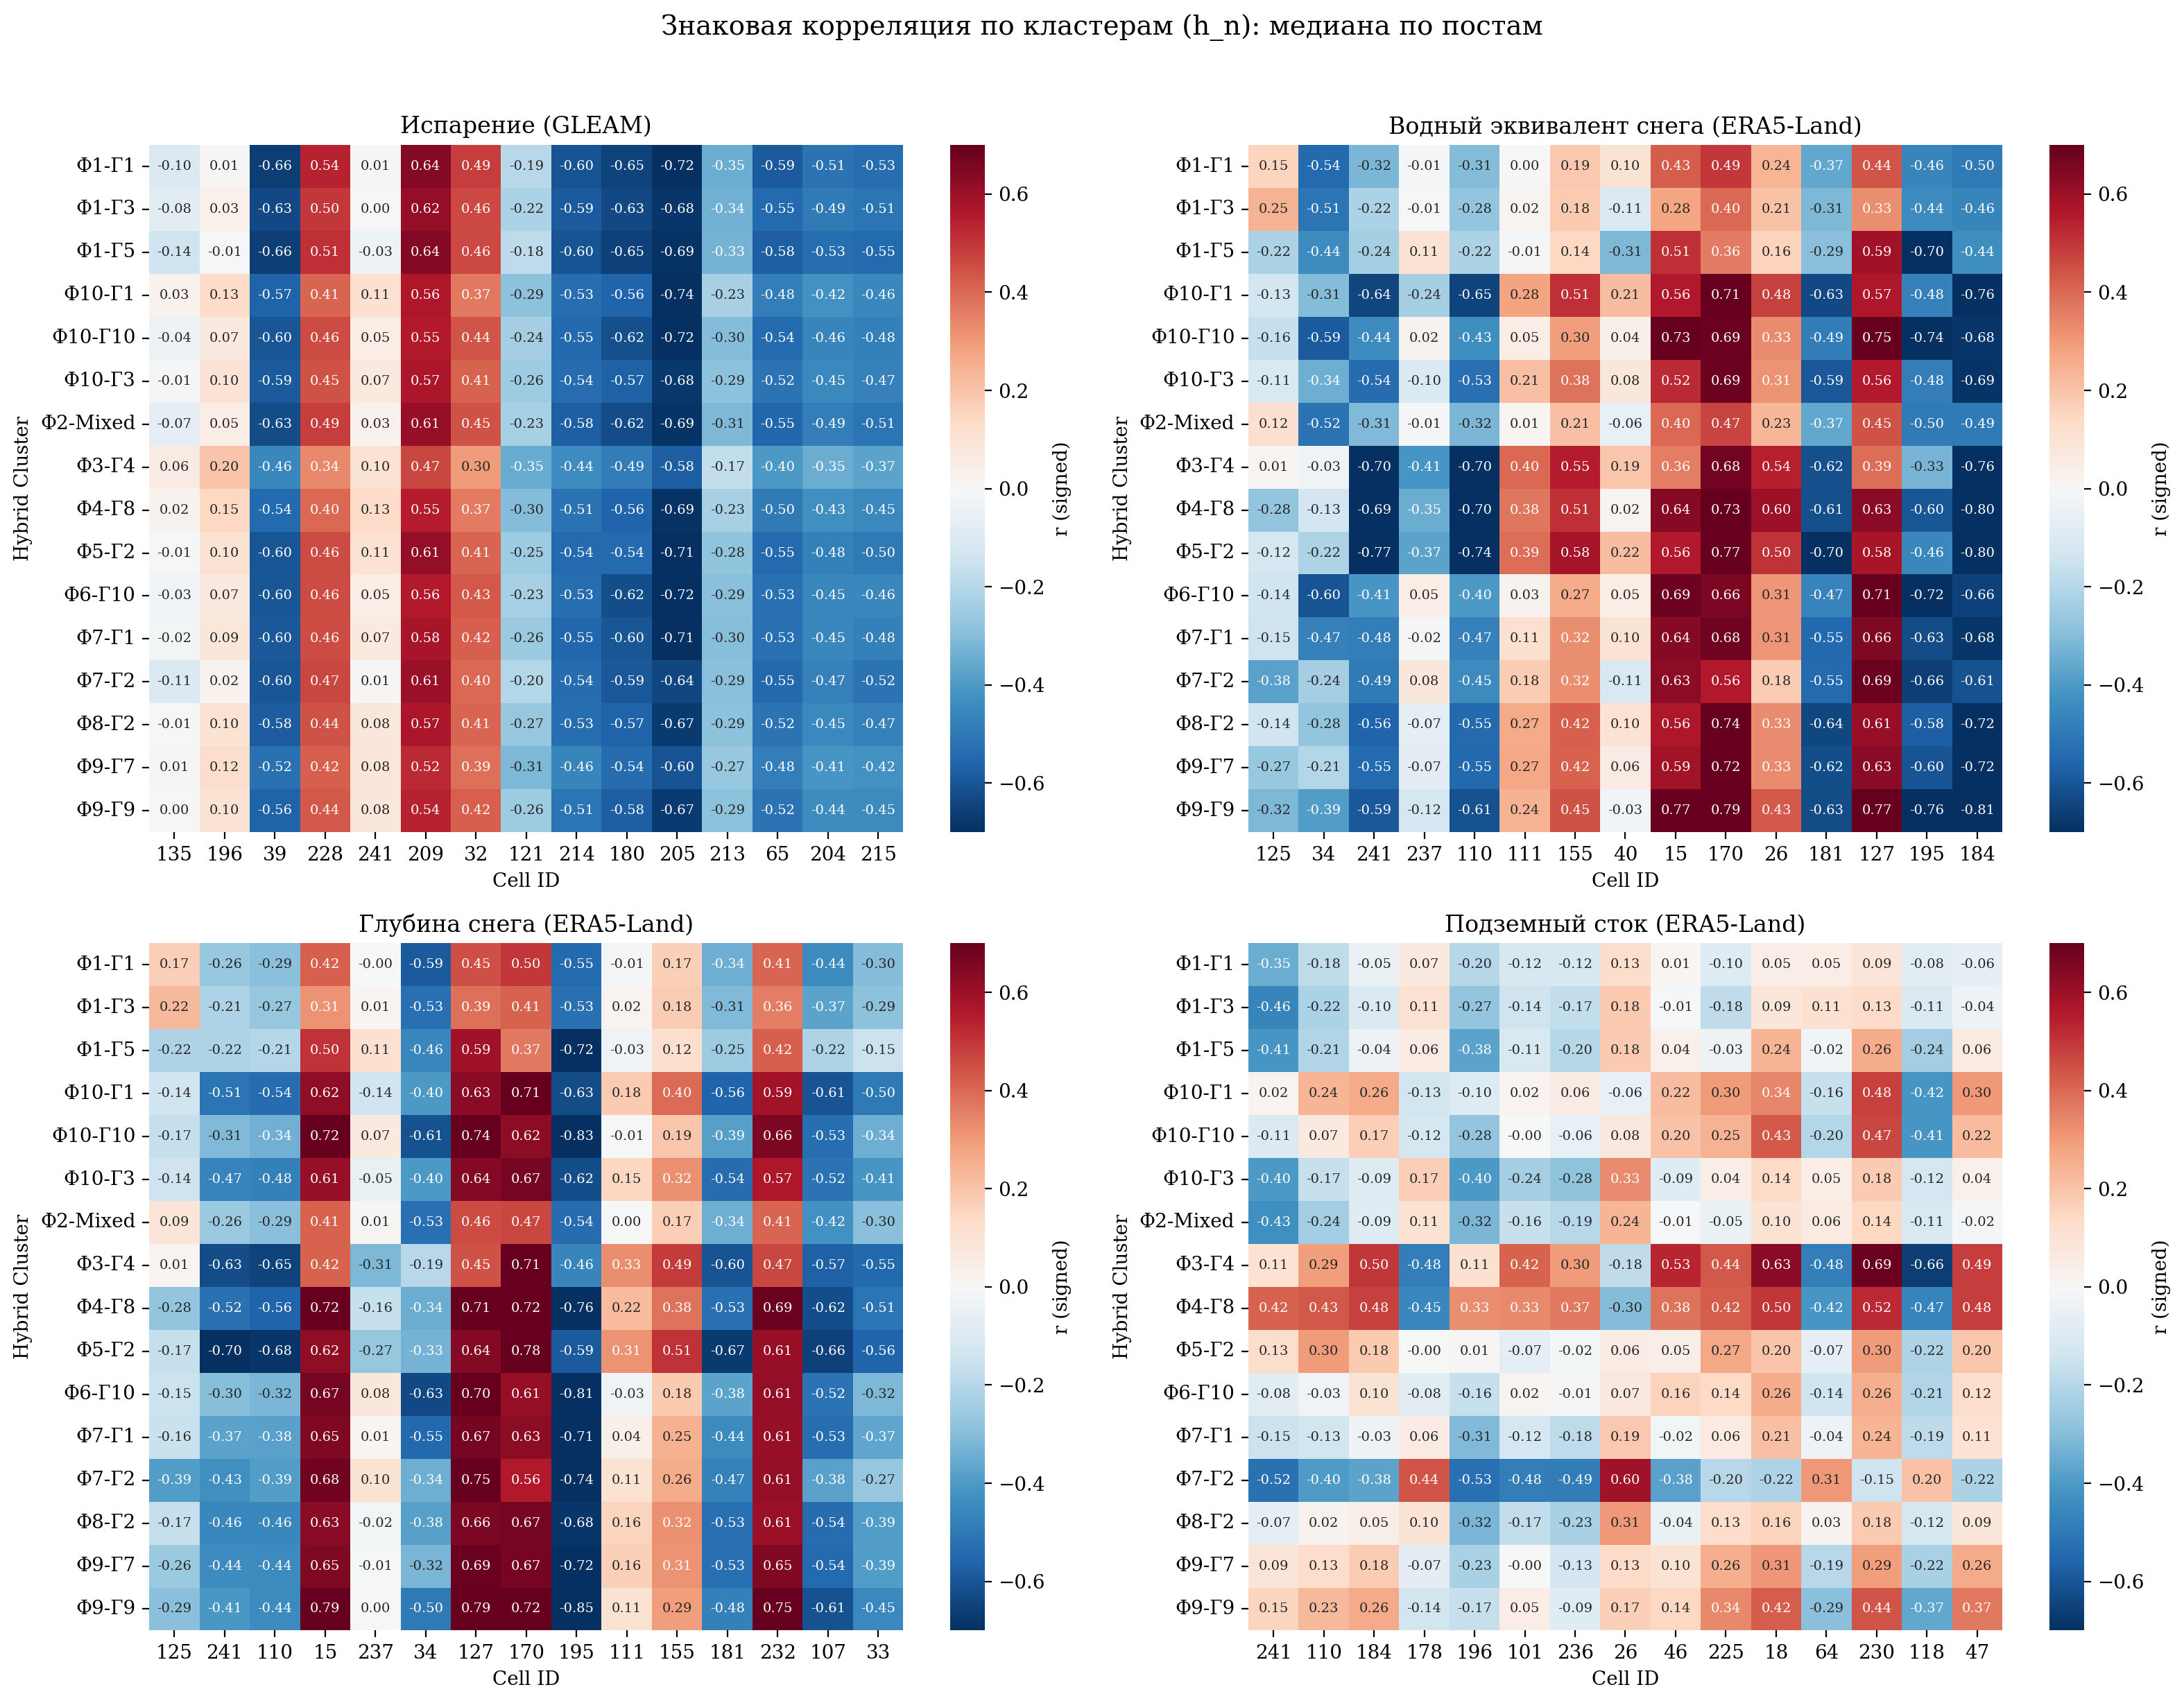

In [22]:
# =============================================================================
# Heatmap: Cluster x Process (signed median correlations)
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (param_name, cluster_df) in enumerate(h_cluster_correlations.items()):
    ax = axes[idx]

    # Top 15 cells by correlation variance across clusters
    cell_variance = cluster_df.var()
    top_cells = cell_variance.nlargest(15).index.tolist()

    plot_data = cluster_df[top_cells]

    sns.heatmap(
        plot_data,
        ax=ax,
        cmap="RdBu_r",
        center=0,
        vmin=-0.7,
        vmax=0.7,
        annot=True,
        fmt=".2f",
        annot_kws={"fontsize": 7},
        cbar_kws={"label": "r (signed)"},
    )
    ax.set_title(f"{METEO_PARAMS[param_name]['description']}", fontsize=12)
    ax.set_xlabel("Cell ID")
    ax.set_ylabel("Hybrid Cluster")

plt.suptitle(
    "Знаковая корреляция по кластерам (h_n): медиана по постам",
    fontsize=14,
    y=1.02,
)
plt.tight_layout()
plt.savefig(
    image_dir / "lstm_v2_hn_cluster_signed_heatmap.png", dpi=150, bbox_inches="tight"
)
plt.show()

In [23]:
# =============================================================================
# Cluster Summary Table
# =============================================================================
cluster_summary = []

for cluster in sorted(hybrid_clusters.unique()):
    cluster_gauges = gauge_cluster_df[gauge_cluster_df["cluster"] == cluster]

    if len(cluster_gauges) == 0:
        continue

    # Dominant group in cluster
    dom_group = cluster_gauges["dominant_group"].value_counts().idxmax()
    dom_pct = cluster_gauges["dominant_group"].value_counts(normalize=True).max() * 100

    # Best cell for dominant process
    base_process = dom_group.rsplit("_", 1)[0] if dom_group != "inactive" else None

    if base_process and base_process in h_cluster_correlations:
        cluster_corr = h_cluster_correlations[base_process]
        if cluster in cluster_corr.index:
            best_cell = cluster_corr.loc[cluster].abs().idxmax()
            best_r = cluster_corr.loc[cluster, best_cell]
        else:
            best_cell, best_r = "N/A", 0
    else:
        best_cell, best_r = "N/A", 0

    cluster_summary.append(
        {
            "Cluster": cluster,
            "N Gauges": len(cluster_gauges),
            "Dominant Group": dom_group,
            "Dom. %": f"{dom_pct:.1f}%",
            "Best Cell": best_cell,
            "Best r": f"{best_r:.3f}" if isinstance(best_r, (int, float)) else best_r,
        }
    )

cluster_summary_df = pd.DataFrame(cluster_summary)
print("=" * 70)
print("CLUSTER SUMMARY (h_n)")
print("=" * 70)
print(cluster_summary_df.to_string(index=False))

CLUSTER SUMMARY (h_n)
 Cluster  N Gauges  Dominant Group Dom. %  Best Cell Best r
   Ф1-Г1        36 evaporation_neg  77.8%          0 -0.872
   Ф1-Г3        35 evaporation_neg  60.0%          0 -0.862
   Ф1-Г5        81 evaporation_neg  70.4%          0 -0.866
  Ф10-Г1        40  snow_depth_neg  40.0%         41 -0.836
 Ф10-Г10        25  snow_depth_neg  84.0%        143 -0.926
  Ф10-Г3       119  snow_depth_neg  47.9%         41 -0.820
Ф2-Mixed        54 evaporation_neg  38.9%          0 -0.861
   Ф3-Г4        31         swe_neg  29.0%        184 -0.760
   Ф4-Г8       157  snow_depth_pos  35.7%        186  0.863
   Ф5-Г2        63  snow_depth_neg  65.1%         41 -0.880
  Ф6-Г10        40  snow_depth_neg  55.0%        197  0.917
   Ф7-Г1        71  snow_depth_neg  46.5%         56 -0.866
   Ф7-Г2        24  snow_depth_neg  50.0%         56 -0.811
   Ф8-Г2        74  snow_depth_neg  56.8%         41 -0.844
   Ф9-Г7       110  snow_depth_pos  42.7%        143 -0.821
   Ф9-Г9        36

# h_n vs c_n Comparison

Compare hidden state (h_n) and cell state (c_n) to see if they specialize in different processes.

In [24]:
# =============================================================================
# Apply cell assignment to c_n (reuse function from above)
# =============================================================================
print("=" * 70)
print("Assigning c_n cells to SIGNED process groups")
print("=" * 70)

c_cell_assignment, c_cell_groups, c_cell_corr_matrix = assign_cells_to_signed_groups(
    c_correlation_matrices, "c_n"
)

print("\nc_n Cell Group Distribution:")
print(c_cell_assignment["primary_group"].value_counts())

Assigning c_n cells to SIGNED process groups

c_n Cell Group Distribution:
primary_group
swe_neg            42
swe_pos            37
evaporation_neg    34
subsurface_pos     31
evaporation_pos    29
subsurface_neg     25
inactive           23
snow_depth_neg     21
snow_depth_pos     14
Name: count, dtype: int64


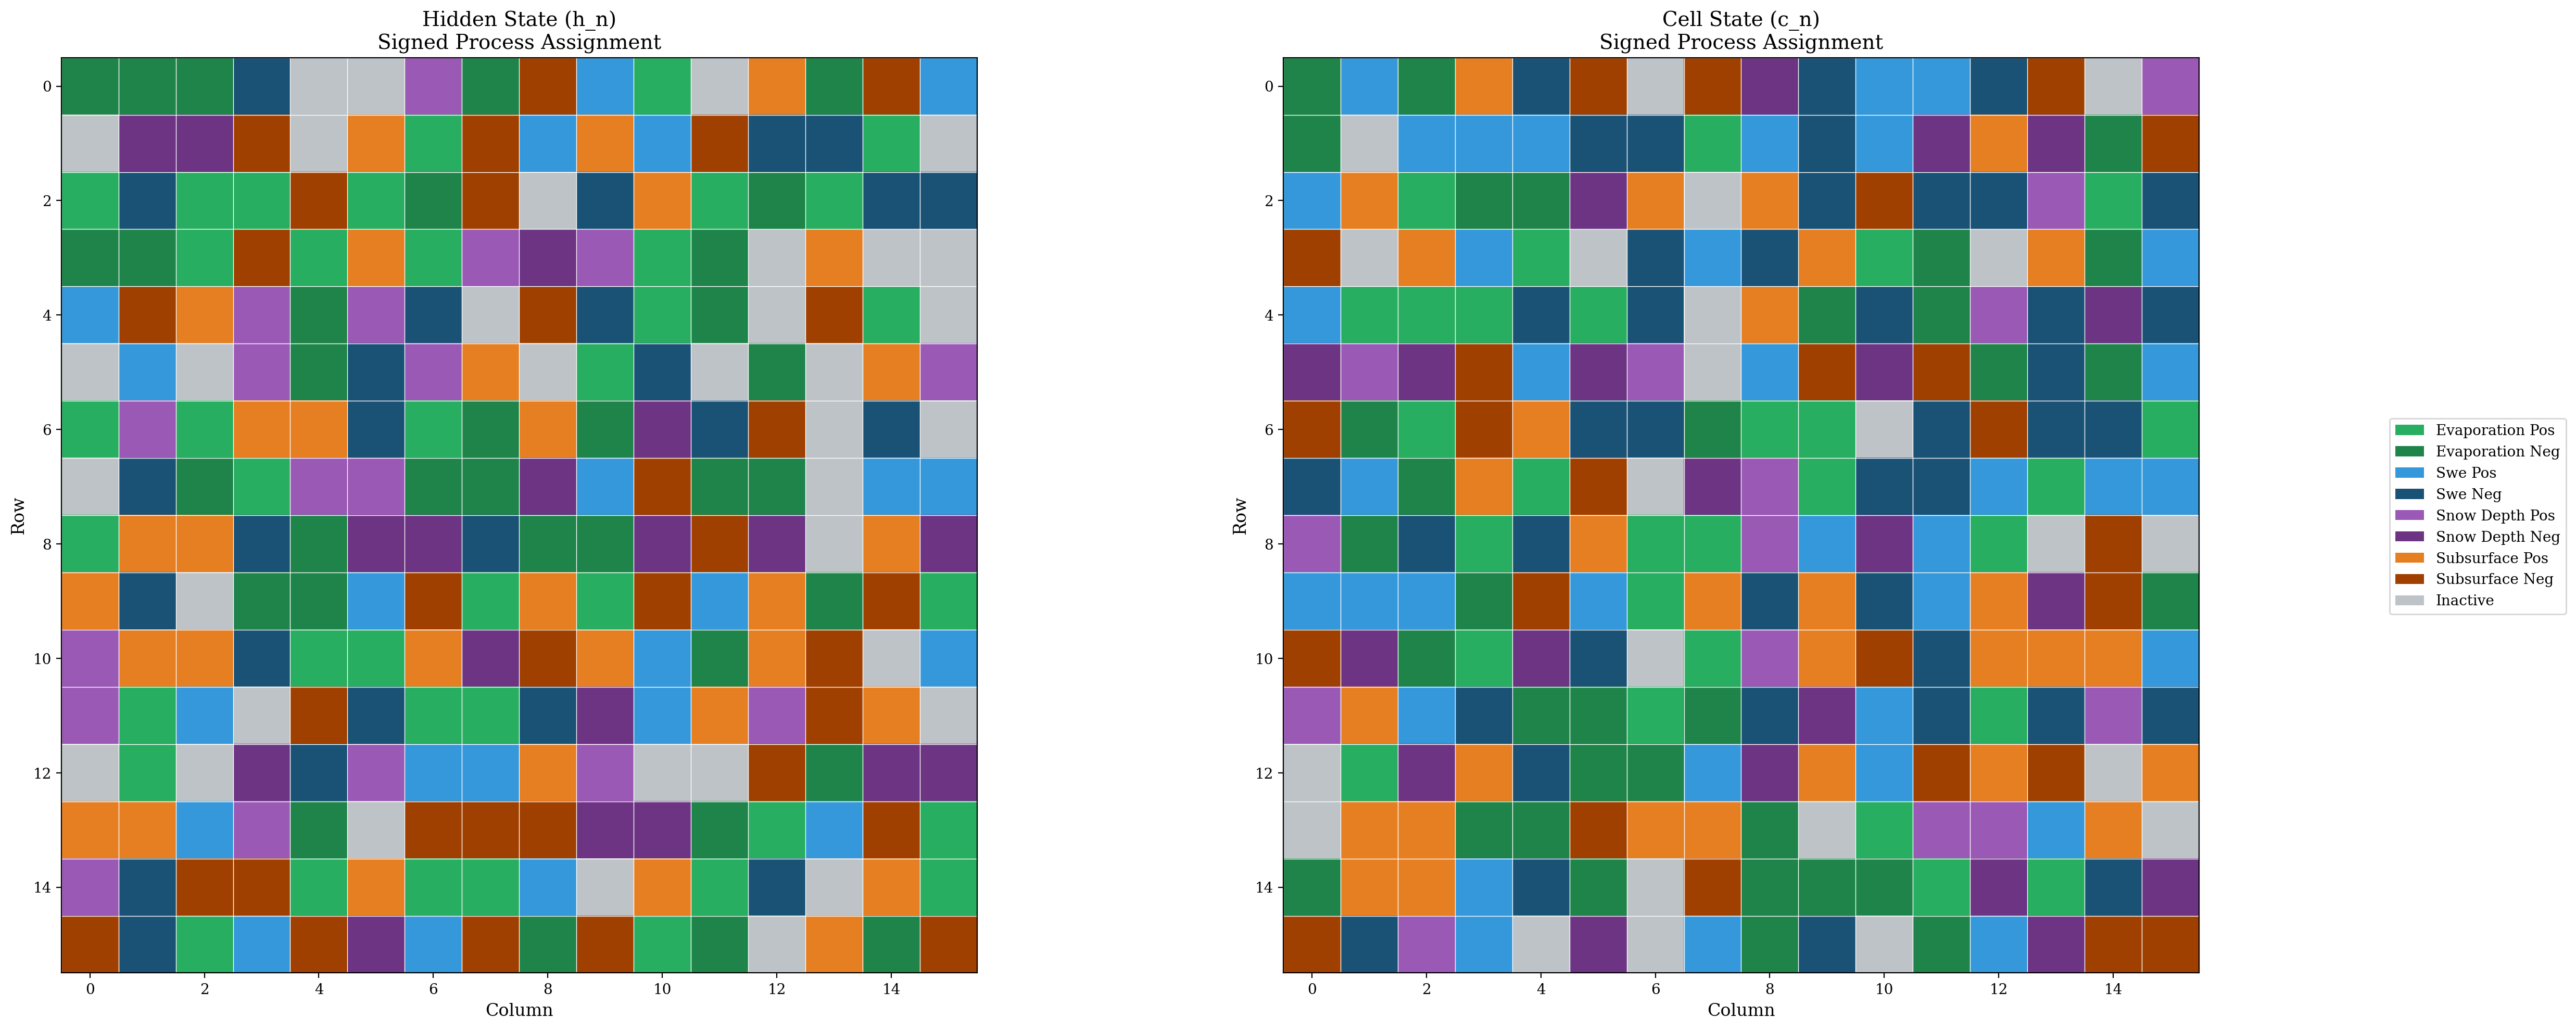

In [25]:
# =============================================================================
# Side-by-side Grid Comparison: h_n vs c_n
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

grid_size = int(np.sqrt(hidden_size))

for ax_idx, (cell_assign, title) in enumerate(
    [
        (h_cell_assignment, "Hidden State (h_n)"),
        (c_cell_assignment, "Cell State (c_n)"),
    ]
):
    ax = axes[ax_idx]
    cell_grid = np.zeros((grid_size, grid_size, 3))

    for cell_id in range(hidden_size):
        row = cell_id // grid_size
        col = cell_id % grid_size
        group = cell_assign.loc[cell_id, "primary_group"]
        color_hex = PROCESS_COLORS.get(group, "#bdc3c7")
        rgb = tuple(int(color_hex.lstrip("#")[j : j + 2], 16) / 255 for j in (0, 2, 4))
        cell_grid[row, col] = rgb

    ax.imshow(cell_grid, aspect="equal")

    for i in range(grid_size + 1):
        ax.axhline(i - 0.5, color="white", linewidth=0.5)
        ax.axvline(i - 0.5, color="white", linewidth=0.5)

    ax.set_xlabel("Column", fontsize=12)
    ax.set_ylabel("Row", fontsize=12)
    ax.set_title(f"{title}\nSigned Process Assignment", fontsize=14)

# Shared legend
legend_elements = [
    Patch(facecolor=color, label=group.replace("_", " ").title())
    for group, color in PROCESS_COLORS.items()
]
fig.legend(
    handles=legend_elements, loc="center right", bbox_to_anchor=(1.08, 0.5), fontsize=10
)

plt.tight_layout()
plt.savefig(image_dir / "lstm_v2_hn_cn_comparison_grid.png", dpi=150, bbox_inches="tight")
plt.show()

In [26]:
# =============================================================================
# Comparison Statistics: h_n vs c_n
# =============================================================================
comparison_data = []

all_groups = set(h_cell_groups.keys()) | set(c_cell_groups.keys())

for group in sorted(all_groups):
    h_cells = set(h_cell_groups.get(group, []))
    c_cells = set(c_cell_groups.get(group, []))

    overlap = h_cells & c_cells
    h_only = h_cells - c_cells
    c_only = c_cells - h_cells

    comparison_data.append(
        {
            "Group": group,
            "h_n": len(h_cells),
            "c_n": len(c_cells),
            "Overlap": len(overlap),
            "h_n only": len(h_only),
            "c_n only": len(c_only),
        }
    )

comparison_df = pd.DataFrame(comparison_data)
print("=" * 70)
print("h_n vs c_n COMPARISON")
print("=" * 70)
print(comparison_df.to_string(index=False))

# Overall agreement
same_assignment = sum(
    1
    for i in range(hidden_size)
    if h_cell_assignment.loc[i, "primary_group"]
    == c_cell_assignment.loc[i, "primary_group"]
)
print(
    f"\nOverall agreement: {same_assignment}/{hidden_size} ({100 * same_assignment / hidden_size:.1f}%)"
)

h_n vs c_n COMPARISON
          Group  h_n  c_n  Overlap  h_n only  c_n only
evaporation_neg   34   34       11        23        23
evaporation_pos   39   29        7        32        22
       inactive   35   23        4        31        19
 snow_depth_neg   18   21        3        15        18
 snow_depth_pos   18   14        2        16        12
 subsurface_neg   33   25        4        29        21
 subsurface_pos   32   31        6        26        25
        swe_neg   25   42        9        16        33
        swe_pos   22   37       13         9        24

Overall agreement: 59/256 (23.0%)


# Time Series Visualization: h_n vs c_n Memory Dynamics

Demonstrate the hypothesis:
- **h_n (hidden state)**: Short-term memory - better for quick/variable processes (evaporation, subsurface)
- **c_n (cell state)**: Long-term memory - better for seasonal/persistent patterns (SWE, snow_depth)

We plot LSTM cell activations alongside meteorological time series to visually confirm correlations.

In [ ]:
# =============================================================================
# Time Series Plotting Function
# =============================================================================
import matplotlib.gridspec as gridspec


def plot_state_vs_meteo(
    gauge_id: str,
    cell_idx: int,
    state_type: str,  # "h_n" or "c_n"
    param_name: str,
    correlation: float,
    ax_cell,
    ax_meteo,
):
    """Plot LSTM cell activations vs meteorological time series."""
    # Load LSTM states for this gauge/cell
    if state_type == "h_n":
        cell_data = h_states[:, cell_idx]
    else:
        cell_data = c_states[:, cell_idx]

    # Load meteorological data
    meteo_data = load_meteo_data(gauge_id, param_name)

    # Align lengths
    min_len = min(len(cell_data), len(meteo_data))
    if min_len < 30:
        ax_cell.text(
            0.5,
            0.5,
            "Insufficient data",
            ha="center",
            va="center",
            transform=ax_cell.transAxes,
        )
        return

    cell_data = cell_data[:min_len]
    meteo_data = meteo_data[:min_len]

    # Create date range (assuming daily data from test period)
    date_range = pd.date_range(start="2019-01-01", periods=min_len, freq="D")

    # Normalize cell data for visualization
    cell_normalized = (cell_data - cell_data.mean()) / (cell_data.std() + 1e-8)

    # Plot cell activations
    ax_cell.plot(date_range, cell_normalized, c="red", alpha=0.8, linewidth=0.8)
    ax_cell.set_ylabel(f"{state_type} cell {cell_idx}", fontsize=9)
    ax_cell.set_title(
        f"Пост {gauge_id}: {state_type}[{cell_idx}] vs {METEO_PARAMS[param_name]['description']}\nr = {correlation:.3f}",
        fontsize=10,
    )
    ax_cell.grid(True, alpha=0.3)
    ax_cell.set_xlim([pd.to_datetime("2019-01-01"), pd.to_datetime("2021-01-01")])

    # Plot meteorological data
    ax_meteo.plot(date_range, meteo_data, c="blue", alpha=0.8, linewidth=0.8)
    ax_meteo.set_ylabel(METEO_PARAMS[param_name]["description"][:20], fontsize=9)
    ax_meteo.grid(True, alpha=0.3)
    ax_meteo.set_xlim([pd.to_datetime("2019-01-01"), pd.to_datetime("2021-01-01")])


def find_best_gauge_cell_pairs(
    correlation_matrices, cell_assignment_df, process_filter, n_samples=3
):
    """Find gauges with highest correlations for a specific process."""
    results = []

    # Get cells assigned to this process
    process_cells = cell_assignment_df[
        cell_assignment_df["primary_group"].str.startswith(process_filter)
    ].index.tolist()

    if not process_cells:
        return results

    # Get correlation matrix for this process
    param_base = process_filter.replace("_pos", "").replace("_neg", "")
    if param_base not in correlation_matrices:
        return results

    corr_df = correlation_matrices[param_base]

    # Find best gauge-cell pairs
    for cell_id in process_cells[:10]:  # Look at top 10 cells
        for gauge_id in corr_df.index[:100]:  # Look at first 100 gauges
            try:
                r = corr_df.loc[gauge_id, cell_id]
                if not np.isnan(r) and abs(r) > 0.3:
                    results.append(
                        {
                            "gauge_id": gauge_id,
                            "cell_idx": cell_id,
                            "correlation": r,
                            "param": param_base,
                        }
                    )
            except (KeyError, IndexError):
                continue

    # Sort by absolute correlation and return top n
    results = sorted(results, key=lambda x: abs(x["correlation"]), reverse=True)
    return results[:n_samples]


print("Time series plotting functions defined.")

In [ ]:
# =============================================================================
# h_n: Short-term Memory - Quick Processes (Evaporation, Subsurface)
# =============================================================================
# Find best gauge-cell pairs for evaporation and subsurface using h_n

evap_pairs = find_best_gauge_cell_pairs(
    h_correlation_matrices, h_cell_assignment, "evaporation", n_samples=3
)
subsurface_pairs = find_best_gauge_cell_pairs(
    h_correlation_matrices, h_cell_assignment, "subsurface", n_samples=3
)

print(
    f"Found {len(evap_pairs)} evaporation pairs, {len(subsurface_pairs)} subsurface pairs"
)

# Create 2x3 grid: top row evaporation, bottom row subsurface
if evap_pairs or subsurface_pairs:
    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(4, 3, hspace=0.4, wspace=0.3)

    # Plot evaporation examples (rows 0-1)
    for i, pair in enumerate(evap_pairs[:3]):
        ax_cell = fig.add_subplot(gs[0, i])
        ax_meteo = fig.add_subplot(gs[1, i])
        plot_state_vs_meteo(
            gauge_id=pair["gauge_id"],
            cell_idx=pair["cell_idx"],
            state_type="h_n",
            param_name="evaporation",
            correlation=pair["correlation"],
            ax_cell=ax_cell,
            ax_meteo=ax_meteo,
        )

    # Plot subsurface examples (rows 2-3)
    for i, pair in enumerate(subsurface_pairs[:3]):
        ax_cell = fig.add_subplot(gs[2, i])
        ax_meteo = fig.add_subplot(gs[3, i])
        plot_state_vs_meteo(
            gauge_id=pair["gauge_id"],
            cell_idx=pair["cell_idx"],
            state_type="h_n",
            param_name="subsurface",
            correlation=pair["correlation"],
            ax_cell=ax_cell,
            ax_meteo=ax_meteo,
        )

    fig.suptitle(
        "h_n (Скрытое состояние): Быстрые процессы\nВерх: Испарение, Низ: Подземный сток",
        fontsize=14,
        y=1.02,
    )

    plt.tight_layout()
    plt.savefig(
        image_dir / "lstm_v2_hn_quick_processes_timeseries.png",
        dpi=150,
        bbox_inches="tight",
    )
    plt.show()
else:
    print("No valid pairs found for visualization")

In [ ]:
# =============================================================================
# c_n: Long-term Memory - Seasonal Processes (SWE, Snow Depth)
# =============================================================================
# Find best gauge-cell pairs for SWE and snow_depth using c_n

swe_pairs = find_best_gauge_cell_pairs(
    c_correlation_matrices, c_cell_assignment, "swe", n_samples=3
)
snow_pairs = find_best_gauge_cell_pairs(
    c_correlation_matrices, c_cell_assignment, "snow_depth", n_samples=3
)

print(f"Found {len(swe_pairs)} SWE pairs, {len(snow_pairs)} snow_depth pairs")

# Create 2x3 grid: top row SWE, bottom row snow_depth
if swe_pairs or snow_pairs:
    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(4, 3, hspace=0.4, wspace=0.3)

    # Plot SWE examples (rows 0-1)
    for i, pair in enumerate(swe_pairs[:3]):
        ax_cell = fig.add_subplot(gs[0, i])
        ax_meteo = fig.add_subplot(gs[1, i])
        plot_state_vs_meteo(
            gauge_id=pair["gauge_id"],
            cell_idx=pair["cell_idx"],
            state_type="c_n",
            param_name="swe",
            correlation=pair["correlation"],
            ax_cell=ax_cell,
            ax_meteo=ax_meteo,
        )

    # Plot snow_depth examples (rows 2-3)
    for i, pair in enumerate(snow_pairs[:3]):
        ax_cell = fig.add_subplot(gs[2, i])
        ax_meteo = fig.add_subplot(gs[3, i])
        plot_state_vs_meteo(
            gauge_id=pair["gauge_id"],
            cell_idx=pair["cell_idx"],
            state_type="c_n",
            param_name="snow_depth",
            correlation=pair["correlation"],
            ax_cell=ax_cell,
            ax_meteo=ax_meteo,
        )

    fig.suptitle(
        "c_n (Состояние ячейки): Сезонные процессы\nВерх: Водный эквивалент снега, Низ: Глубина снега",
        fontsize=14,
        y=1.02,
    )

    plt.tight_layout()
    plt.savefig(
        image_dir / "lstm_v2_cn_seasonal_processes_timeseries.png",
        dpi=150,
        bbox_inches="tight",
    )
    plt.show()
else:
    print("No valid pairs found for visualization")

In [27]:
# =============================================================================
# Save Results
# =============================================================================
# Save h_n cell assignments
h_cell_assignment.to_csv(table_dir / "lstm_v2_hn_cell_assignment.csv")
print(f"Saved: {table_dir / 'lstm_v2_hn_cell_assignment.csv'}")

# Save c_n cell assignments
c_cell_assignment.to_csv(table_dir / "lstm_v2_cn_cell_assignment.csv")
print(f"Saved: {table_dir / 'lstm_v2_cn_cell_assignment.csv'}")

# Save h_n vs c_n comparison
comparison_df.to_csv(table_dir / "lstm_v2_hn_cn_comparison.csv", index=False)
print(f"Saved: {table_dir / 'lstm_v2_hn_cn_comparison.csv'}")

# Save cluster summary
cluster_summary_df.to_csv(table_dir / "lstm_v2_cluster_summary.csv", index=False)
print(f"Saved: {table_dir / 'lstm_v2_cluster_summary.csv'}")

# Save gauge dominant process
gauge_dominant_df.to_csv(table_dir / "lstm_v2_gauge_dominant.csv")
print(f"Saved: {table_dir / 'lstm_v2_gauge_dominant.csv'}")

# Save cluster crosstab
crosstab.to_csv(table_dir / "lstm_v2_cluster_crosstab.csv")
print(f"Saved: {table_dir / 'lstm_v2_cluster_crosstab.csv'}")

print("\nAll results saved!")

Saved: ../res/chapter_three/tables/lstm_v2_hn_cell_assignment.csv
Saved: ../res/chapter_three/tables/lstm_v2_cn_cell_assignment.csv
Saved: ../res/chapter_three/tables/lstm_v2_hn_cn_comparison.csv
Saved: ../res/chapter_three/tables/lstm_v2_cluster_summary.csv
Saved: ../res/chapter_three/tables/lstm_v2_gauge_dominant.csv
Saved: ../res/chapter_three/tables/lstm_v2_cluster_crosstab.csv

All results saved!


# Summary

## Key Improvements in v2

1. **Signed correlations preserved**: Cells are assigned to `{process}_pos` or `{process}_neg` groups
2. **Z-score ranking**: Ensures all processes get representation (fixes subsurface underrepresentation)
3. **Both h_n and c_n analyzed**: Side-by-side comparison shows how hidden vs cell states differ
4. **Time series visualizations**: Visually confirm h_n vs c_n memory dynamics
5. **Streamlined flow**: 26 cells vs 45 in v1

## h_n vs c_n Memory Hypothesis

- **h_n (hidden state)**: Short-term memory - captures quick/variable processes (evaporation, subsurface)
- **c_n (cell state)**: Long-term memory - captures seasonal/persistent patterns (SWE, snow depth)

The time series plots demonstrate this difference: h_n cells track rapid fluctuations while c_n cells follow smoother seasonal cycles.

## Output Files

### Tables
- `lstm_v2_hn_cell_assignment.csv` - h_n cell assignments with signed groups
- `lstm_v2_cn_cell_assignment.csv` - c_n cell assignments with signed groups
- `lstm_v2_hn_cn_comparison.csv` - Comparison statistics
- `lstm_v2_cluster_summary.csv` - Cluster-level summary
- `lstm_v2_gauge_dominant.csv` - Per-gauge dominant process
- `lstm_v2_cluster_crosstab.csv` - Cluster x process cross-tabulation

### Figures
- `lstm_v2_hn_signed_cell_grid.png` - 16x16 grid of h_n cells
- `lstm_v2_hn_signed_dominant_process_map.png` - Point map of dominant process
- `lstm_v2_hn_signed_correlation_hexmap.png` - Hex map with diverging colors
- `lstm_v2_hn_cluster_signed_heatmap.png` - Cluster x cell heatmap
- `lstm_v2_hn_cn_comparison_grid.png` - Side-by-side h_n vs c_n grids
- `lstm_v2_hn_quick_processes_timeseries.png` - h_n time series: evaporation, subsurface
- `lstm_v2_cn_seasonal_processes_timeseries.png` - c_n time series: SWE, snow depth